# Analyzing DNA binding mutants 

In [184]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import pandas as pd
import glob
import sys
sys.path.insert(0, '../../')
import mut.viz
import mut.thermo
import mut.stats
import mut.bayes
import pystan
colors = mut.viz.pub_style()
%matplotlib inline

In [99]:
# Define the files
files = glob.glob('../../data/csv/2018*.csv')
dfs = [pd.read_csv(i, comment='#') for i in files]
df = pd.concat(dfs, ignore_index=True)

# Remove the auto and delta strains. 
idx_id = {'Q21M':0, 'Q21A':1, 'Y20I':2}

df = df[df['mutant'] != 'wt']
df = df[(df['fold_change'] >= -0.1) & (df['fold_change'] <= 1.2)]
df = df[(df['mutant'] != 'auto') & (df['mutant'] != 'delta')]
df['idx'] = [idx_id[df.iloc[i]['mutant']] for i in range(len(df))]
grouped = df.groupby(['mutant', 'strain', 'IPTGuM'])


/Users/gchure/anaconda/lib/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


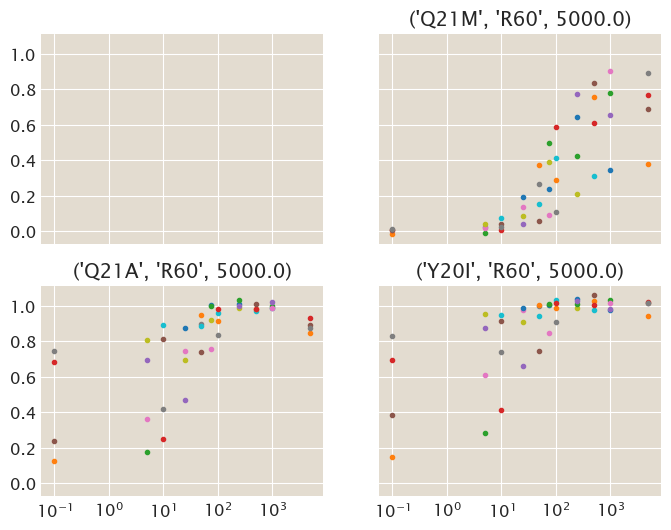

In [100]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax = ax.ravel()
axes = {'wt':ax[0], 'Q21M':ax[1], 'Q21A':ax[2], 'Y20I':ax[3]}
for a in ax:
    a.set_xscale('log')
for g, d in grouped:
    axes[g[0]].plot(d['IPTGuM'].mean(), d['fold_change'].mean(), '.')
    axes[g[0]].set_title(g)

It will be better to fit the log fold change I think. Let's just try things with the WT to make sure they are working as expected. 

In [101]:
# Look only at the leakiness values. 
leakiness = df[df['IPTGuM'] == 0]

In [102]:
leakiness

,IPTGuM,Unnamed: 0,date,fold_change,ind,mean_FITC_H,mutant,operator,repressors,strain,username,idx
0,0.0,20.0,20180213,0.011940,NaN,5082.246850,Q21M,O2,260.0,R260,gchure,0
2,0.0,39.0,20180213,0.020366,NaN,5174.999030,Q21M,O2,124.0,R124,gchure,0
5,0.0,76.0,20180213,-0.036631,NaN,4547.600381,Q21M,O2,1220.0,R1220,gchure,0
6,0.0,83.0,20180213,-0.017009,NaN,4763.588403,Q21M,O2,60.0,R60,gchure,0
85,0.0,34.0,20180226,0.775912,NaN,14472.741347,Y20I,O2,60.0,R60,sbarnes,2
87,0.0,68.0,20180226,0.433157,NaN,10231.524735,Y20I,O2,260.0,R260,sbarnes,2
89,0.0,71.0,20180226,0.148118,NaN,6704.483596,Y20I,O2,1220.0,R1220,sbarnes,2
90,0.0,81.0,20180226,0.760321,NaN,14279.820304,Y20I,O2,124.0,R124,sbarnes,2
169,0.0,NaN,20180311,0.170627,38.0,7953.163416,Q21A,O2,1220.0,R1220,nbellive,1
171,0.0,NaN,20180311,0.371620,50.0,11911.121747,Q21A,O2,260.0,R260,nbellive,1


In [115]:
model = """
functions {
    /**
    * Compute the probability of a repressor being active given an inducer
    * concentration c.
    *
    * @param c Concentration of allosteric effector.
    * @param ep_a Log transform of effector dissociation constant from active
    *        repressor, Ka, in kBT.
    * @param ep_i Log transform of effector dissociation constant from inactive
    *        repressor, Ki, in kBT.
    * @param ep_ai Energy difference between the active and inactive state of
    *        the repressor in kBT.
    * @param n_sites The number of allosterically dependent sites.
    * @return prob_act The probability of a repressor being active with the
    *         given parameters.
    **/
    real prob_act(real c, real ep_a, real ep_i, real ep_ai, int n_sites) {
        // Calculate the relevant components piecewise for simplicity.
        real numerator;
        real denominator;
        numerator = (1 + c * exp(-ep_a))^n_sites;
        denominator = numerator + exp(-ep_ai) * (1 + c * exp(-ep_i))^n_sites;
        return numerator / denominator;}

    /**
    * Compute the level of repression in a simple repression architecture.
    *
    * @param pact The probability of an active repressor.
    * @param R The number of repressors per cell.
    * @param Nns The number of nonspecific binding sites.
    * @param ep_r The binding energy of the repressor to the DNA in kBT.
    * @return repression The level of repression given these parameters.
    **/
    real repression(real pact, real R, real Nns, real ep_r) {
        return 1 + pact * (R / Nns) * exp(-ep_r);
      }

    /**
    * Calculate the fold-change in gene expression.
    *
    * @param R The number of repressors per cell
    * @param Nns The number of nonspecific repressor binding sites.
    * @param ep_r The  binding energy of the repressor to the DNA in kBT.
    * @param c The concentration of allosteric effector.
    * @param ep_a The log transform of the effector dissociation constant from
    *        the active repressor, Ka, in kBT.
    * @param ep_i The log tranform of the effector dissociation constant from
    *        the active repressor, Ki, in kBT.
    * @param ep_ai The energetic difference between the active and inactive
    *        states of the repressor in kBT.
    * @param n_sites The number of allostericaly dependent effector binding
    *        sites.
    **/
    real fold_change(real R, real Nns, real ep_r, real c, real ep_a, real ep_i,
                    real ep_ai, int n_sites) {
        // Compute the various componenets piecewise for simplicity.
        real pact;
        real rep;
        pact = prob_act(c, ep_a, ep_i, ep_ai, n_sites);
        rep = repression(pact, R, Nns, ep_r);
        return rep^-1;
        }
      }
data { 
    int N; # Number of samples
    real<lower=-0.2, upper=1.2> fc[N];
    real<lower=0> R[N];
    real<lower=0> c[N];
    real ep_ai;
    real ep_a;
    real ep_i;
    real n_ns;
    int n_sites;
    }
    
parameters {
    real ep_r;
    real sigma;
    }
    
model { 
    vector[N] mu;
    for (i in 1:N) {
        mu[i] = fold_change(R[i], n_ns, ep_r, c[i], ep_a, ep_i, ep_ai, n_sites);
    }
   
   # Set the priors
   ep_r ~ normal(0, 10);
   sigma ~ beta(0.5, 0.5);
   fc ~ normal(mu, sigma);
    }
"""
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecc44f2e37b1f8eb5dc0f0111c606284 NOW.


In [155]:
Y20I = leakiness[leakiness['mutant'] == 'Y20I']
data_dict = {'N':len(Y20I), 'R':Y20I['repressors'].values, 'c':Y20I['IPTGuM'].values,
            'ep_ai': 4.5, 'ep_a': -np.log(139/1E6), 'ep_i': -np.log(0.53/1E6), 'n_ns':4.6E6, 'n_sites':2,
            'fc': Y20I['fold_change'].values}
fit = sm.sampling(data=data_dict, iter=10000,  chains=4)

In [156]:
fit

Inference for Stan model: anon_model_ecc44f2e37b1f8eb5dc0f0111c606284.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
ep_r   -9.89  5.1e-4   0.05  -9.99  -9.92  -9.89  -9.85  -9.78  11276    1.0
sigma   0.04  1.0e-4 9.0e-3   0.03   0.04   0.04   0.05   0.07   7847    1.0
lp__    43.7    0.02   1.17  40.49  43.25  44.06  44.54  44.84   5525    1.0

Samples were drawn using NUTS at Thu Mar 15 16:12:25 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

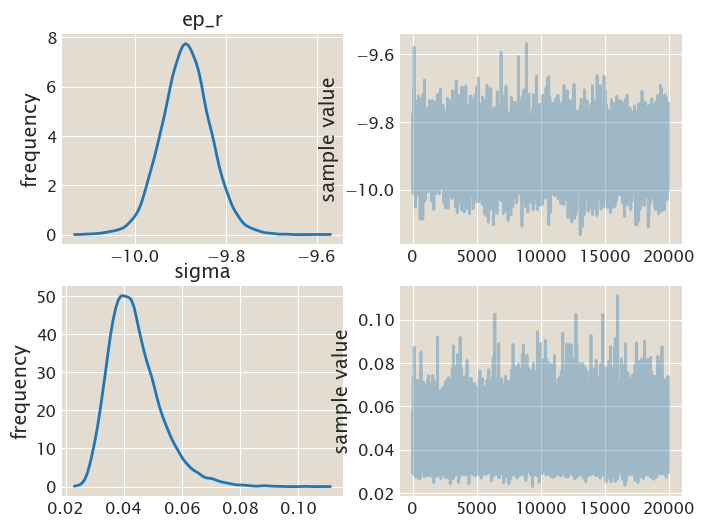

In [157]:
_ = fit.plot()

In [198]:
dfs = []
stats = []
for i, m in enumerate(leakiness['mutant'].unique()):
    # Set up the model.
    mutant = leakiness[leakiness['mutant']==m]
    with pm.Model() as model:
        # Set the priors for the binding energy
        ep = pm.Normal('ep_{}'.format(m), mu=0, sd=10)
        sigma = pm.HalfNormal('sigma_{}'.format(m), sd=10)
    
        # Compute the log fold change. 
        arch = mut.thermo.SimpleRepression(R=mutant['repressors'].values, ep_r=ep,
                                              ka=153, ki=0.53, ep_ai=4.5, effector_conc=0)
        mu = arch.fold_change()
    
        like = pm.Normal('like', mu=mu, sd=sigma, observed=mutant['fold_change'].values)
        trace = pm.sample(tune=5000, draws=10000, njobs=4)
        trace_df = mut.stats.trace_to_dataframe(trace, model)
        trace_stats = mut.stats.compute_statistics(trace_df)
        dfs.append(trace_df)
        stats.append(trace_stats)
        
stats = pd.concat(stats, ignore_index=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_Q21M_log__, ep_Q21M]
INFO:pymc3:NUTS: [sigma_Q21M_log__, ep_Q21M]
100%|██████████| 15000/15000 [00:26<00:00, 574.25it/s]
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 686 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 686 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.677957663755, but should be close to 0.8. Try to increase the number of tuning steps.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
E

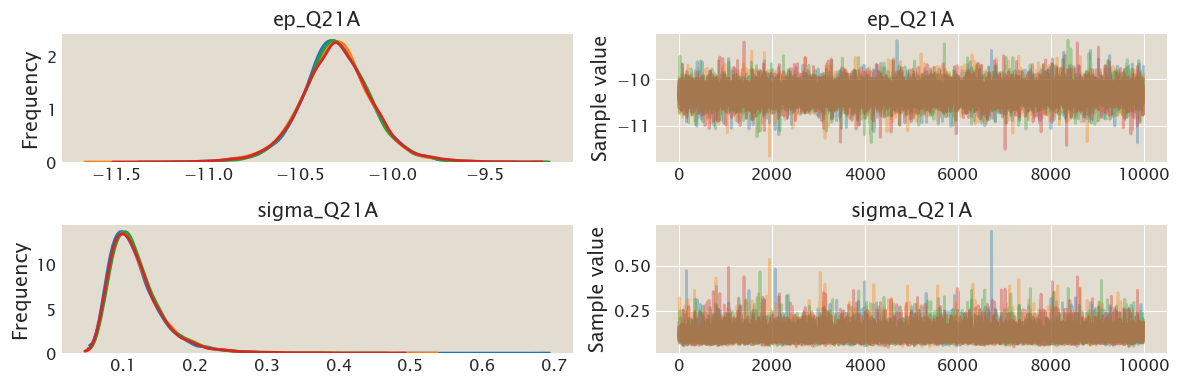

In [199]:
_ = pm.traceplot(trace)

In [200]:
stats

,parameter,mode,hpd_min,hpd_max
0,ep_Q21M,-15.812760,-26.372754,-14.795788
1,sigma_Q21M,0.015784,0.011575,0.023975
2,ep_Y20I,-9.887098,-9.993435,-9.772534
3,sigma_Y20I,0.040784,0.028949,0.062953
4,ep_Q21A,-10.305180,-10.701640,-9.913687
5,sigma_Q21A,0.098476,0.062007,0.194277


In [201]:
# Extract the modes.
modes = {}
muts = leakiness['mutant'].unique()
for k, v in enumerate(muts):
    modes[v] = stats[stats['parameter']=='ep_{}'.format(v)]['mode'].values[0]

In [202]:
muts

array(['Q21M', 'Y20I', 'Q21A'], dtype=object)

In [203]:
leakiness.repressors.unique().astype(int)

array([ 260,  124, 1220,   60])

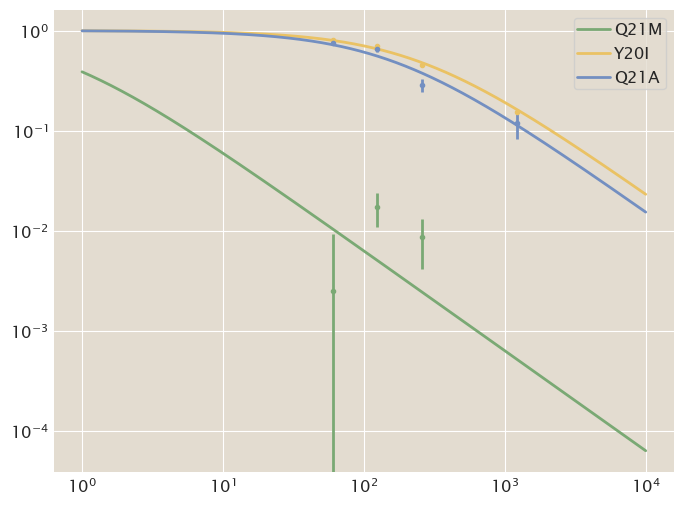

In [204]:
# Plot them. 
color=list(colors.values())[::3]
rep_range = np.logspace(0, 4, 500)
for i, k in enumerate(modes.keys()):
    # Grab the data. 
    _d = leakiness[leakiness['mutant']==k].groupby('repressors')
    mu = _d['fold_change'].mean().values

    err = _d['fold_change'].std() / np.sqrt(len(_d))
    err = err.values
    reps = _d.repressors.unique()
    
    plt.plot(reps, mu,'.', color=color[i])
    plt.errorbar(reps, mu, err, color=color[i], linestyle='none')
    theo = mut.thermo.SimpleRepression(R=rep_range, ep_r=modes[k], ka=153, 
                                       ki=0.53, ep_ai=4.5, effector_conc=0) 
    plt.loglog(rep_range, theo.fold_change(), color=color[i], label=k)

plt.legend()

In [205]:
err.values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
def compute_mean_sem(df):
    stat_dict = {'mean': np.mean(df), 'sem': np.std(df) / len(df)}
    return pd.Series(stat_dict)

grouped = df.groupby(['mutant', 'repressors', 'IPTGuM'])['fold_change']

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharey=True, sharex=True)
ax = ax.ravel()
for a in ax:
    a.set_xscale('log')
    a.set_xlabel('IPTG [M]')
    a.set_ylabel('fold-change')
axes = {'Q21M':ax[0], 'Q21A':ax[1], 'Y20I':ax[2]}
titles = list(axes.keys())
for i in range(3):
    ax[i].grid(False)
    ax[i].set_title(titles[i])

reps = df.repressors.unique()
c_range = np.logspace(-8, -2, 500)
c_map = list(colors.values())[::3]
c_dict = {r:c for r, c in zip(reps, c_map)}
for i, m in enumerate(axes.keys()):
    for j, r in enumerate(reps):
        
        # Calculate the confidence interval         
        theo = mut.thermo.SimpleRepression(R=r, ep_ai=4.5, ka=139E-6, ki=0.53E-6, 
                                           effector_conc=c_range, ep_r=modes[m]).fold_change()
        
        
        _ = axes[m].plot(c_range, theo, color=c_map[j], label=int(r))

for g, d in grouped:
    _ = axes[g[0]].errorbar(g[2] / 1E6, np.mean(d), np.std(d) / np.sqrt(len(d)), fmt='o', color=c_dict[g[1]], 
                           markersize=2.5)
_ = ax[0].legend(fontsize=10)

ax[0].set_xlim([1E-8, 1E-2])
plt.tight_layout()